#Table of Contents
* [1. Fitting a local equilibrium model to foam scan data](#1.-Fitting-a-local-equilibrium-model-to-foam-scan-data)
	* [1.1 Load data](#1.1-Load-data)
	* [1.2 Experimental data](#1.2-Experimental-data)
	* [1.3 Assign values to the physical parameters](#1.3-Assign-values-to-the-physical-parameters)
	* [1.4 Fit a new liquid relperm](#1.4-Fit-a-new-liquid-relperm)
	* [1.5 Relative permeability curves](#1.5-Relative-permeability-curves)
	* [1.6 Visualize RelPerms](#1.6-Visualize-RelPerms)
	* [1.7 Define the foam model](#1.7-Define-the-foam-model)
* [2. Boeije-Rossen method](#2.-Boeije-Rossen-method)
	* [2.1 Compare the model vs measured saturations](#2.1-Compare-the-model-vs-measured-saturations)
* [3. Ma et al. model](#3.-Ma-et-al.-model)
* [4. Nonlinear least-square model](#4.-Nonlinear-least-square-model)
	* [4.1 Calculate the liquid saturation for data points](#4.1-Calculate-the-liquid-saturation-for-data-points)
	* [4.2 Calculate the experimental foam parameters](#4.2-Calculate-the-experimental-foam-parameters)
	* [4.3 Create and solve a JuMP model: three parameters](#4.3-Create-and-solve-a-JuMP-model:-three-parameters)
	* [4.4 Create and solve a JuMP model: five parameters](#4.4-Create-and-solve-a-JuMP-model:-five-parameters)
	* [4.5 Visualize the results](#4.5-Visualize-the-results)
* [5. A discontinuous model](#5.-A-discontinuous-model)


# 1. Fitting a local equilibrium model to foam scan data

The data of Joris's thesis is used here. Experiments K, L, M, Bentheimer sandstone, 1.78 Darcy, at 25 degC with a back pressure of 80 bar.

In [1]:
using JuMP, Roots, PyPlot, Ipopt, DataFrames, NLopt, PyCall, Optim
@pyimport scipy.optimize as so
@pyimport CoolProp.CoolProp as CP
PyPlot.rc("font", family="sans")

INFO: Loading help data...


## 1.1 Load data of Joris

First, I read the data table using the `DataFrames` package.

In [2]:
# experiment K, L, M
T= 80+273.15 # [K]
k= 1.86e-12 # [m^2] perm
D_core= 0.038 # [m]
L_in= 0.135 # [m]
L_core= 0.18 # [m]
mu_liq= CP.PropsSI("V","T",T,"P",80e5,"H2O") # mu [Pa.s], T [K], P [Pa]
mu_gas= CP.PropsSI("V","T",T,"P",80e5,"N2") # mu [Pa.s], T [K], P [Pa]

2.143552082507864e-5

In [3]:
#data1=readtable("AOS_0.03_N2_benth_expK.csv")
#data2=readtable("AOS_0.1_N2_benth_expL.csv")
data1=readtable("AOS_0.5_N2_benth_80degC.csv")

,ut,muf_tot,muf_in,fg_in,fg_out,dp16,dp40,P_in
1,1.4628e-5,0.031788,0.012715,0.2962,0.29732,0.09,0.45,80.45
2,1.4603e-5,0.036796,0.0084914,0.39545,0.39693,0.06,0.52,80.52
3,1.4576e-5,0.043245,0.015596,0.49498,0.4968,0.11,0.61,80.61
4,1.4547e-5,0.049723,0.02273,0.59491,0.59693,0.16,0.7,80.7
5,1.4515e-5,0.059089,0.029901,0.69521,0.69731,0.21,0.83,80.83
6,1.447e-5,0.078552,0.038562,0.79583,0.79795,0.27,1.1,81.1
7,1.4415e-5,0.1043,0.043011,0.89726,0.89884,0.3,1.455,81.455
8,1.4409e-5,0.095739,0.035857,0.94862,0.94939,0.25,1.335,81.335
9,1.4424e-5,0.068059,0.021492,0.97951,0.97974,0.15,0.95,80.95
10,1.4445e-5,0.089418,0.042921,0.84644,0.84836,0.3,1.25,81.25


## 1.2 Experimental data

In [4]:
# Foam quality
u = float(data1[:ut]) # [m/s]
fg_exp = float(data1[:fg_in]+data1[:fg_out])/2.0 # [-]
# Foam apparent viscosity [Pa.s]
muf_exp = float(data1[:muf_tot]) # [Pa.s]
n_data = length(u)
# Viscosity data [Pa.s]
muw = mu_liq*ones(n_data)
mug = mu_gas*ones(n_data)
# filter the low quality data for the low quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_low= find(fg_exp.<=fg_trans)
fg_low= fg_exp[ind_fg_low]
muf_low= muf_exp[ind_fg_low]
muw_low= muw[ind_fg_low]
# filter the high quality data for the high quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_high= find(fg_exp.>=fg_trans)
fg_high= fg_exp[ind_fg_high]
muf_high= muf_exp[ind_fg_high]
println("Data is loaded.")

Data is loaded.


## 1.3 Assign values to the physical parameters

In [5]:
# IFT value [N/m]
sigma_wg = 0.03;

## 1.5 Relative permeability curves

In [6]:
# Relperm data
swc = 0.169997 
sgr = 0.0479002
krg0 = 0.94
ng = 1.8
krw0 = 0.336417 
nw = 2.49292  
sws(sw::Real)=((sw>swc)*(sw<1-sgr)*(sw-swc)/(1-sgr-swc)+(sw>=1-sgr)*1.0)
sws(sw::Array{Float64})=((sw.>swc).*(sw.<1-sgr).*(sw-swc)/(1-sgr-swc)+
(sw.>=1-sgr).*ones(size(sw)))
kr(sw)=((sw.>=swc).*krg0.*(1-sws(sw)).^ng+(sw.<swc).*(1+(krg0-1)/swc*sw))
krw(sw)=((sw.<=1-sgr).*krw0.*sws(sw).^nw+(sw.>1-sgr).*
(-(1-krw0)/sgr.*(1.0-sw)+1.0))

krw (generic function with 1 method)

## 1.6 Visualize RelPerms

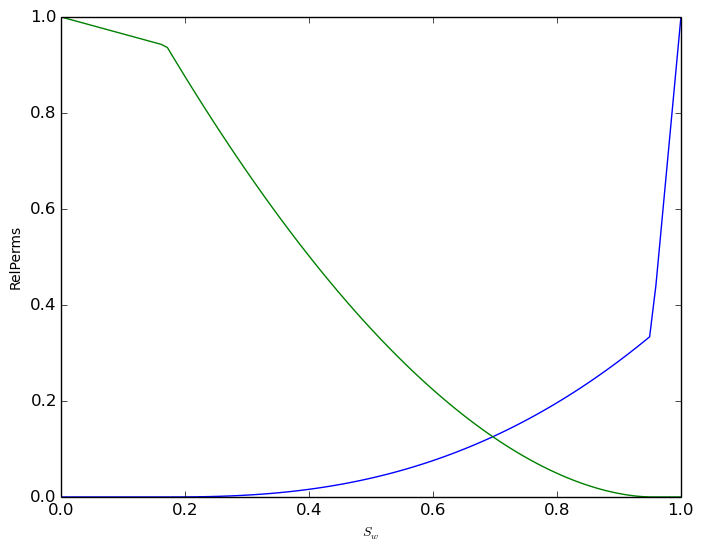

PyObject <matplotlib.text.Text object at 0x7feac1b85590>

In [7]:
sw_plot = linspace(0.0,1.0, 100)
plot(sw_plot, krw(sw_plot), sw_plot, kr(sw_plot))
xlabel(L"S_w")
ylabel("RelPerms")

## 1.7 Define the foam model

In [8]:
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2)=(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u)=(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 1 method)

## 4.1 Calculate the liquid saturation for data points

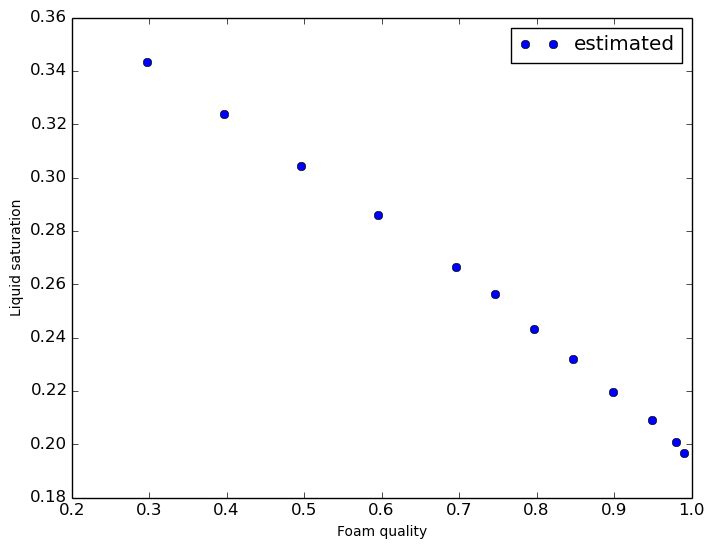

In [9]:
sw_exp = (1-swc-sgr)*(muw.*(1-fg_exp)./(krw0*muf_exp)).^(1/nw)+swc
labdaw = krw(sw_exp)./muw
labdag = kr(sw_exp)./mug
plot(fg_exp, sw_exp, "o")
xlabel("Foam quality")
ylabel("Liquid saturation")
legend(["estimated", "measured"]);

# 2. Boeije-Rossen method

I'm trying to automate the Boeije-Rossen method, using linear regression for the high quality and power-law for the low quality region.

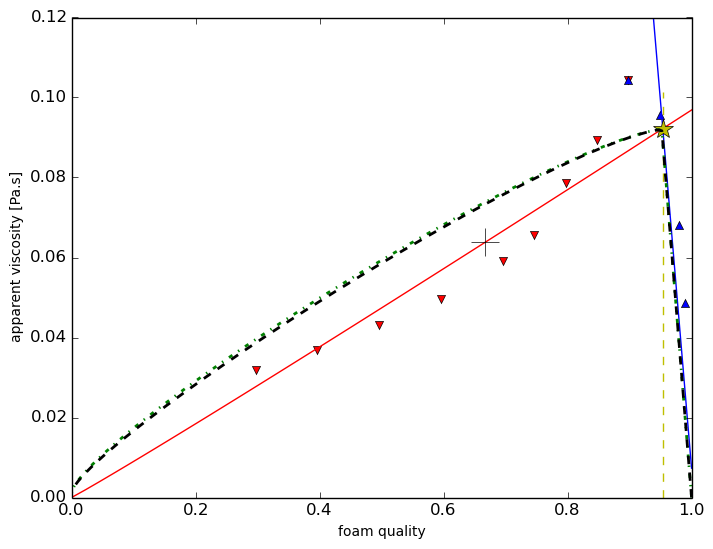

5-element Array{Float64,1}:
   3753.04      
 100000.0       
      0.208023  
      1.54998e-5
     -0.0304312 

In [10]:
# fit a line to the high quality data; note: y=a+b*x
w1=ones(length(fg_high)+1) # weight factor
w1[end]=100.0
w1[end-3:end-1]=20.0
a_high=linreg([fg_high;1.0], [muf_high;0.0], w1)
#a_high[1]=-a_high[2] # force it to go through point [1,0]
# fit a power law to the low quality data
# y=a*x^b; log(y)=log(a)+b*log(x)
w2=ones(length(fg_low)) # weight factor
w2[end-3:end]=1.0 # a larger weight to the points near the transition
a_low=linreg(log(fg_low),log(muf_low), w2)
fg_low_range=linspace(0.0, maximum(fg_low)+0.2, 50)
fg_high_range=linspace(maximum(fg_low),1.0, 10)
plot(fg_low, muf_low, "vr", fg_low_range, exp(a_low[1])*fg_low_range.^a_low[2], "r-")
plot(fg_high, muf_high, "b^", fg_high_range, a_high[1]+a_high[2]*fg_high_range, "b-")
# find the transition quality
fun1(x)=exp(a_low[1])*x^a_low[2]-(a_high[1]+a_high[2]*x)
fg_trans = fzero(fun1, maximum(fg_low))
muf_trans = a_high[1]+a_high[2]*fg_trans
plot(fg_trans, muf_trans, "*y", markersize=15, [fg_trans, fg_trans], [0.0, 1.1*muf_trans], "--y", linewidth=1)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
# find the transition saturation (or fmdry)
sw_trans = (1-swc-sgr)*(muw[ind_mu_max].*(1-fg_trans)./(krw0*muf_trans)).^(1/nw)+swc
fmdry_br= sw_trans
# find fmmob
FM_trans = mug[ind_mu_max]/muw[ind_mu_max]*fg_trans/(1-fg_trans)*(krw(sw_trans)/kr(sw_trans))
fmmob_br= 1.0/FM_trans-1.0
# find epdry
epdry_br= 100000.0 # very convenient
# visualize the three-parameter fit
x_br=[fmmob_br, epdry_br, fmdry_br]
sw_val = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
fg_opt = fg(sw_val, x_br)
muf_opt = mu_foam(sw_val, x_br)
plot(fg_opt, muf_opt, "-.g", linewidth=2)
# calculate the epcap
dryout(x, sw)=0.5+atan(x[1]*(sw-x[2]))/π
fg_plus=0.7*fg_trans
muf_plus= exp(a_low[1])*fg_plus^a_low[2]
plot(fg_plus, muf_plus, "k+", markersize=20)
sw_plus=(1-swc-sgr)*(muw[ind_mu_max].*(1-fg_plus)./(krw0*muf_plus)).^(1/nw)+swc
#FM_plus = mug[ind_mu_max]/muw[ind_mu_max]*fg_plus/(1-fg_plus)*(krw(sw_plus)/kr(sw_plus))
#epcap_br=log((1.0/FM_trans-1.0)/(1.0/FM_plus-1.0)*
#dryout([epdry_br,fmdry_br],sw_plus)/dryout([epdry_br,fmdry_br],sw_trans))/log(muf_plus/muf_trans)
epcap_br=log((kr(sw_trans)*muf_plus-fg_plus*mug[ind_mu_max])/
(fmmob_br*mug[ind_mu_max]*fg_plus))/log(muf_trans/muf_plus)
# calculate fmcap
ind_muf_min = indmin(muf_exp)
fmcap_br= muf_exp[ind_muf_min]*u[ind_muf_min]/sigma_wg
# correct for fmmob
fmmob_br_new = fmmob_br*(muf_trans/muf_exp[ind_muf_min])^epcap_br
# visualize the final results
x_br2= [fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]
sw_p = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n1 = length(sw_p)
muf_opt = zeros(n1)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n1
    fmu(x)= x-mu_foam2(sw_p[i], x_br2[1:3], x_br2[4:5], x, u_ave)
    muf_opt[i]=fzero(fmu, 0.9)
end
plot(fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), mu_foam2(sw_p, x_br2[1:3], 
x_br2[4:5], muf_opt, u_ave), "k--", linewidth=2)
axis([0.0,1.0,0.0,0.12])
fit_br=[fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]

## 2.1 Compare the model prediction vs measured saturations

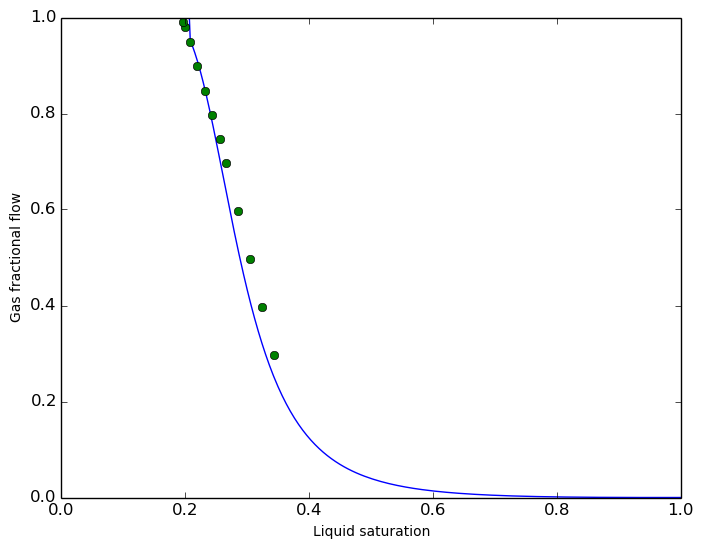

PyObject <matplotlib.text.Text object at 0x7feac184cf50>

In [11]:
plot(sw_p, fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")

# 3. Ma et al. model

The optimization procedure of Ma et al. can be impplemented as follows:

# 4. Nonlinear least-square model

## 4.2 Calculate the experimental foam parameters

See our paper for more details.

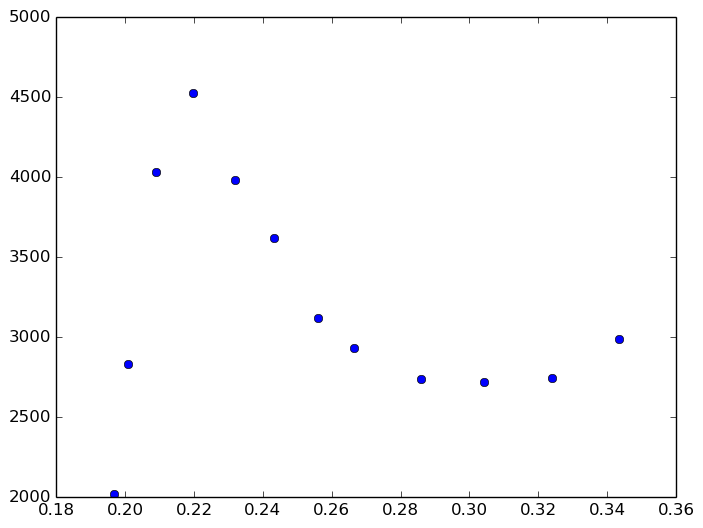

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7feac14f5ad0>

In [25]:
#FM = mug./muw.*fg_exp./(1-fg_exp).*(krw(sw_exp)./kr(sw_exp))
FM = mug.*fg_exp./(kr(sw_exp).*muf_exp)
f_foam = 1.0./FM-1.0;
plot(sw_exp, f_foam, "o")

## 4.3 Create and solve a JuMP model: three parameters


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



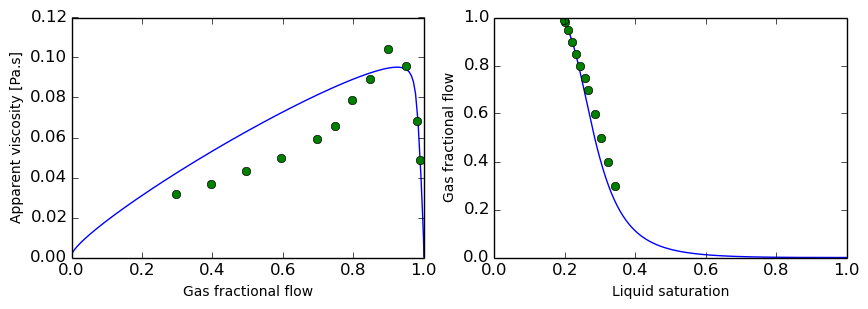

3-element Array{Float64,1}:
 4206.9     
  456.771   
    0.197074

In [13]:
m1 = Model(solver=IpoptSolver(print_level=1))
#m1 = Model(solver=NLoptSolver(algorithm=:LD_TNEWTON_RESTART))
#m = Model()
# define the variables of the foam model
@defVar(m1, 10<=fmmob<=500000)
@defVar(m1, 10<=epdry<=50000, start=100)
@defVar(m1, swc<=fmdry<=swc+0.4)
w=ones(length(muf_exp))
ind_mu_max= indmax(muf_exp)
w[ind_mu_max-1:ind_mu_max+1]=10
#@setNLObjective(m1, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)))^2, i=1:n_data})
#@setNLObjective(m, Min, sum{w[i]*(tan(f_foam[i]/fmmob-0.5)-(epdry*(sw_exp[i]-fmdry))/pi)^2, i=1:n_data})
#@setNLObjective(m1, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
#    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)))^2, i=1:n_data})
@setNLObjective(m1, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi))))^2, i=1:n_data})
solve(m1)
# get the result
x1 = [getValue(fmmob), getValue(epdry), getValue(fmdry)]
sw_val = linspace(0,1.0, 500)
fg_opt = fg(sw_val, x1)
muf_opt = mu_foam(sw_val, x1)
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg_opt, muf_opt, fg_exp, muf_exp, "o")
xlabel("Gas fractional flow")
ylabel("Apparent viscosity [Pa.s]")
subplot(1,2,2)
plot(sw_val, fg_opt, sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")
x1

## 4.4 Create and solve a JuMP model: five parameters

Here's a list of NLopt algorithms (note: "NLOPT_{G,L}{N,D}_xxxx, where G/L denotes global/local optimization and N/D denotes derivative-free/gradient-based algorithms, respectively"  
  - GN_DIRECT_L
  - GN_DIRECT
  - GN_DIRECT_L_RAND
  - GN_DIRECT_NOSCAL
  - GN_DIRECT_L_NOSCAL
  - GN_DIRECT_L_RAND_NOSCAL
  - GN_ORIG_DIRECT_L
  - GN_CRS2_LM
  - G_MLSL_LDS
  - GN_MLSL
  - GD_STOGO
  - GD_STOGO_RAND
  - GN_ISRES
  - GN_ESCH
  - LN_COBYLA
  - LN_BOBYQA
  - LN_NEWUOA_BOUND
  - LN_NEWUOA
  - LN_PRAXIS
  - LN_NELDERMEAD
  - LN_SBPLX
  - LD_MMA
  - LD_CCSAQ
  - LD_SLSQP
  - LD_LBFGS
  - LD_TNEWTON_PRECOND
  - LD_TNEWTON_PRECOND_RESTART
  - LD_TNEWTON
  - LD_TNEWTON_RESTART
  - LD_VAR2
  - LD_VAR1

In [14]:
m2 = Model(solver=IpoptSolver(print_level=1))
#m2 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@defVar(m2, 10<=fmmob<=500000, start=x1[1])
#@defVar(m2, epdry==100000)
@defVar(m2, 10<=epdry<=100000, start=x1[2])
@defVar(m2, swc<=fmdry<=sw_exp[ind_mu_max])
#@defVar(m2, 1e-7<=fmcap<=1e-4, start=fmcap_br)
@defVar(m2, fmcap==fmcap_br)
@defVar(m2, -2.0<=epcap<=2.0, start=-0.5)
w[ind_mu_max-4:ind_mu_max+1]=100
#@setNLObjective(m2, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
@setNLObjective(m2, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
#    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})

# solve it
solve(m2)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
 1955.33      
  273.121     
    0.193589  
    1.54998e-5
   -0.741971  

In [15]:
fit_br
sw_exp[ind_mu_max]


0.21963631224085228

## 4.5 Visualize the results

One method is to calculate the pressure drop in different gas and liquid rates, and plot the pressure drop contours versus gas and liquid velocity. The following result is visualized for a few average total flow rates.

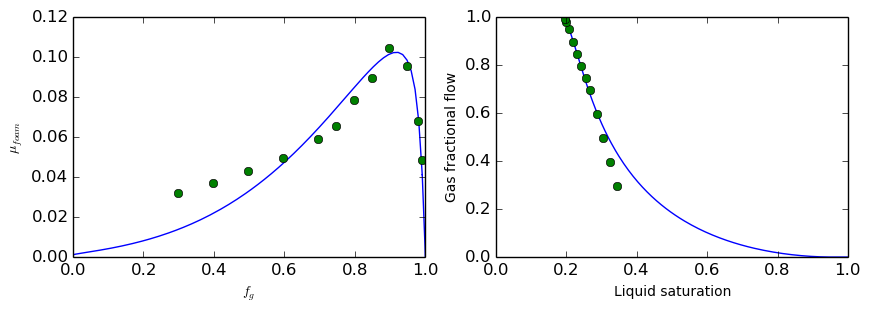

In [16]:
sw_plot = [linspace(eps(), minimum(sw_exp), 50); linspace(minimum(sw_exp)+eps()-0.00001, maximum(sw_exp), 50); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    mu_guess=mu_foam(sw_plot[i], x2[1:3])
    mu_upper=so.fminbound(fmu, 0.0, 4.0)
    if sw_plot[i]<0.212
        mu_lower=0.0
    else
        mu_lower=so.fminbound(fmu2, 1e-4, 3.0)
    end
    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
    #muf_opt[i]=fzero(fmu2, mu_guess)
end
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave), "-")
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")
subplot(1,2,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow");

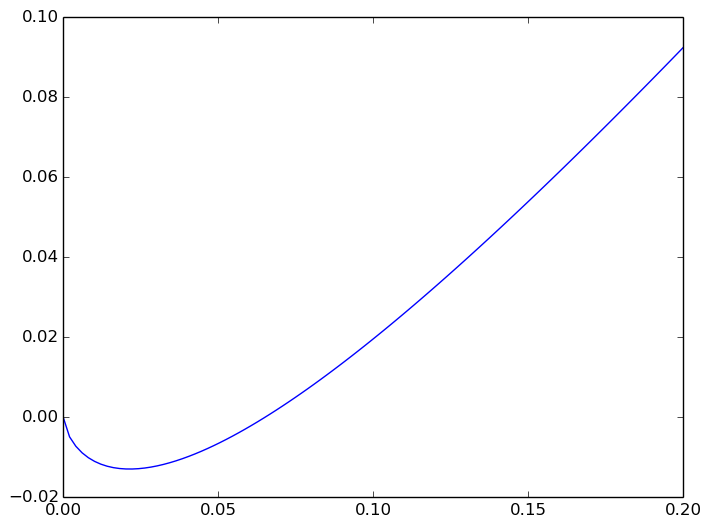

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7feac159e910>

In [17]:
mu1=linspace(0,0.2,100)
fmu(x)= (x-mu_foam2(0.26262004951044005, x2[1:3], x2[4:5], x, u_ave))
fmu1=zeros(length(mu1))
for i=1:length(mu1)
    fmu1[i]=fmu(mu1[i])
end
plot(mu1,fmu1)

## Using Optim package

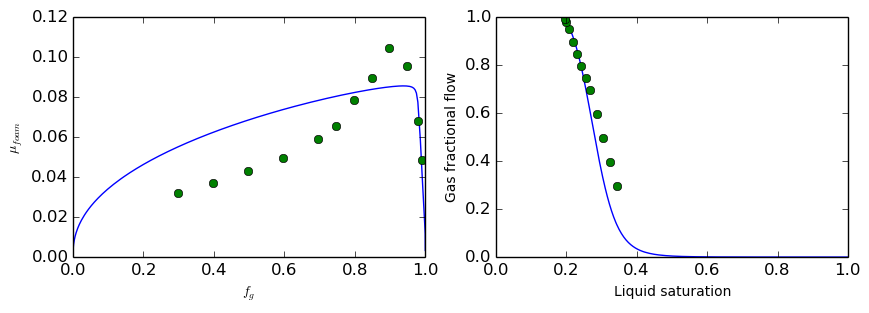

5-element Array{Float64,1}:
 10000.0       
  1000.0       
     0.198356  
     1.52234e-5
     1.00062   

In [18]:
w[ind_mu_max-3:ind_mu_max+2]=100
f_obj(x)= sum(w.*(FM-1.0./(1.0+x[1]*(0.5+atan(x[2]*(sw_exp-x[3]))/pi).*(x[4]./(u.*muf_exp/sigma_wg)).^x[5])).^2)
x_low=[10.0, 10.0, swc, 1e-7, -4.0]
x_high=[5.0e6, 1.0e6, 0.4, 1.0e-4, 4.0]
d4 = DifferentiableFunction(f_obj)
opt_out=fminbox(d4, [1.0e4, 1.0e3, swc+0.02, 1e-5, 1.0], x_low, x_high)
x2=opt_out.minimum
sw_plot = [linspace(eps(), minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    mu_upper=so.fminbound(fmu, 0.0, 5.0)
    mu_lower=so.fminbound(fmu2, 0.0, 5.0)
    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
end
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave))
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")
subplot(1,2,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow");
x2

# 5. A discontinuous model

Note: $f_g$ --> 0, $\mu_{app}$ --> $\mu_{app,0}$  
The first step is to fit a curve (line, polynomial, or power law) to the low quality regime and find the $\mu_{app,0}$. Then, the new functions that are defined below will be used to fit the foam scan data.

In [19]:
# define the new model with mu_app0
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2, mu0)=mu0+(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u, mu0)=mu0+(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 2 methods)

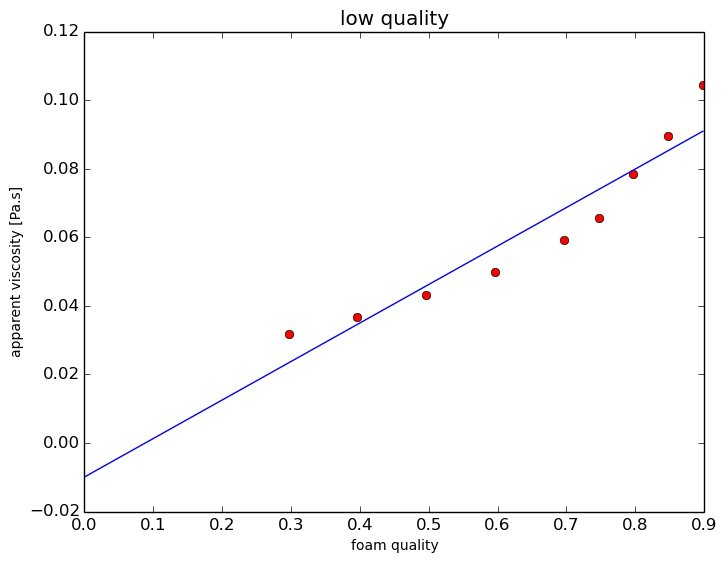

PyObject <matplotlib.text.Text object at 0x7feac17c66d0>

In [20]:
(muf_0,dmudfg)=linreg(fg_low, muf_low)
fg_low_range=linspace(0.0, maximum(fg_low), 20)
plot(fg_low, muf_low, "or", fg_low_range, dmudfg*fg_low_range+muf_0)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
title("low quality")

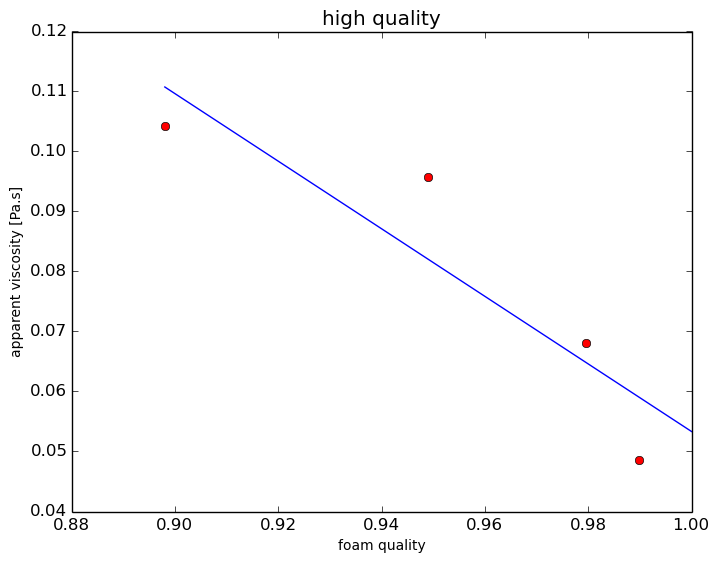

0.05332936778695618

In [21]:
(muf_end,dmudfg)=linreg(fg_high, muf_high)
fg_high_range=linspace(minimum(fg_high), 1.0, 20)
plot(fg_high, muf_high, "or", fg_high_range, dmudfg*fg_high_range+muf_end)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
title("high quality")
[dmudfg*fg_high_range+muf_end][end]

A negative value is obtained. The fit is not really a fit. I would say at fg=0, we can go with the gas viscosity.

In [22]:
plot(fg_low, sw_low, "or")
(sw_0,dswdfg)=linreg(fg_low, sw_low)
plot(fg_low, sw_low, "or", fg_low_range, dswdfg*fg_low_range+sw_0)
xlabel("foam quality")
ylabel("liquid saturation")
title("low quality")
sw_0

LoadError: sw_low not defined
while loading In[22], in expression starting on line 1

In [23]:
plot(fg_high, sw_high, "or")
(sw_end,dswdfg)=linreg(fg_high, sw_high)
plot(fg_high, sw_high, "or", fg_high_range, dswdfg*fg_high_range+sw_end)
xlabel("foam quality")
ylabel("liquid saturation")
title("high quality")
[dswdfg*fg_high_range+sw_end][end]

LoadError: sw_high not defined
while loading In[23], in expression starting on line 1